# Simulations with SPAM errors

## Introduction
In the introductory tutorial `Simulating sequences with errors and noises`, we introduced SPAM errors and here we will go into more detail. We recommend you to check the introductory tutorial before going through this one.

The State Preparation And Measurement(SPAM) errors encapsulate as its name indicates the errors that can occur during state preparation and measurements. They can be:
* A state preparation error (with probability η for each atom), where an atom is not correctly pumped to the ground state at the beginning, making it effectively unavailable throughout the sequence.
* Measurement errors which are linked to the incorrect identification of the atoms final state: during the imaging process, excited rydberg atoms in $\Ket{r}$ might decay to the state $\Ket{g}$, allowing them to be trapped in the tweezers : those are the false negatives modeled by $\epsilon'$. 
On the contrary, some atoms in the ground state $\Ket{g}$ might be kicked out for various reasons (e.g. collisions with residual gas in the chamber) and tweezers recapture might fail, inferring them incorrectly as atoms in the excited state $\Ket{r}$ : those are the false positives modeled by $\epsilon$.


In [13]:
import numpy as np
import matplotlib.pyplot as plt
import qutip

from pulser import Register, Pulse, Sequence
from pulser_simulation import SimConfig, Simulation
from pulser.devices import Chadoq2
from pulser.waveforms import ConstantWaveform, RampWaveform

## Single atom noisy simulations

### Sequence preparation

We prepare a single atom.

In [14]:
reg = Register.from_coordinates([(0, 0)], prefix="q")

We act on this atom with a Constant Pulse, such that it oscillates towards the excited rydberg state and back to the original state (Rabi oscillations):

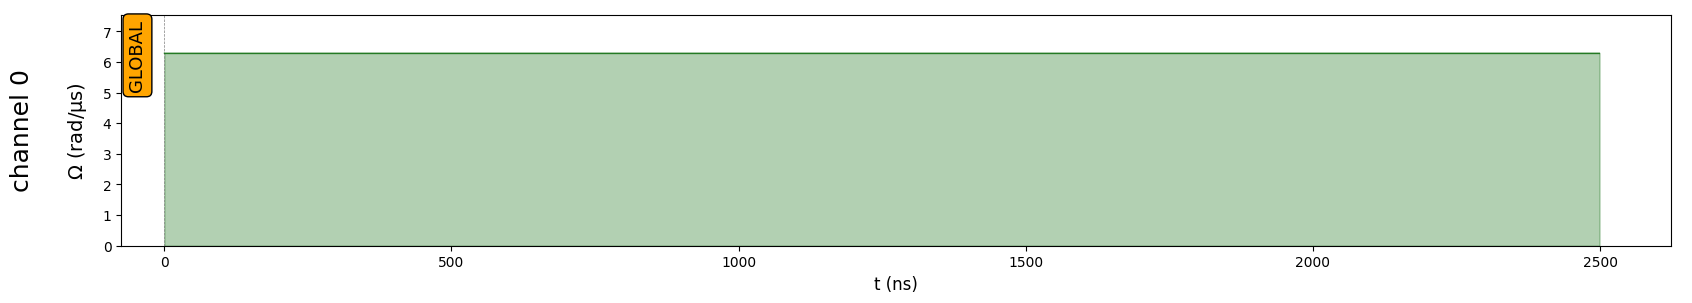

In [15]:
seq = Sequence(reg, Chadoq2)
seq.declare_channel("channel 0", "rydberg_global")
duration = 2500
pulse = Pulse.ConstantPulse(duration, 2 * np.pi, 0.0, 0.0)
seq.add(pulse, "channel 0")
seq.draw()

We now create the simulation object and instantiate an observable which describes the excited state population.

In [16]:
sim = Simulation(seq, sampling_rate=0.05)
obs = qutip.basis(2, 0).proj()

## SPAM effects

In this part we compare both clean and noisy simulations for the default SPAM parameters (taken from [De Léséleuc, et al., 2018](https://arxiv.org/abs/1802.10424))

In [19]:
# SPAM configuration
config_spam = SimConfig(noise=("SPAM"), runs=30, samples_per_run=5)

# Integration of the SPAM noise configuration to the simulation
sim.set_config(config_spam)
sim.show_config()

# Simulation storing 40% of the results:
sim.evaluation_times = 0.4
res_spam = sim.run()

Options:
----------
Number of runs:        30
Samples per run:       5
Noise types:           SPAM
SPAM dictionary:       {'eta': 0.005, 'epsilon': 0.01, 'epsilon_prime': 0.05}


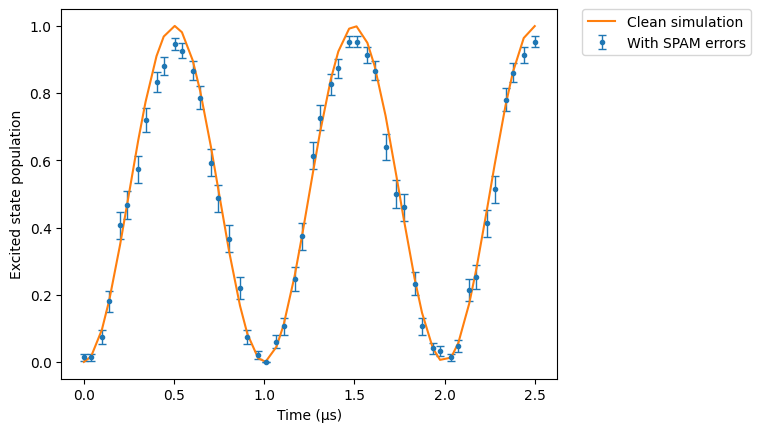

In [20]:
res_spam.plot(obs, label="With SPAM errors")

# Clean simulation:
sim.reset_config()
res_clean = sim.run()
res_clean.plot(obs, label="Clean simulation")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0)
plt.ylabel("Excited state population")
plt.show()

Let's modify the *SPAM* dictionary allowing more badly prepared atoms($40$%).

Text(0, 0.5, 'Excited state population')

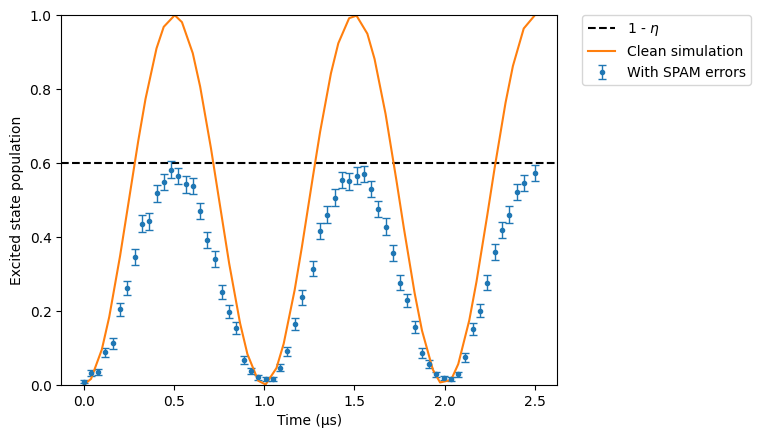

In [21]:
config_spam_mod = SimConfig(noise=("SPAM"), eta=0.4, runs=100)
sim.set_config(config_spam_mod)
sim.evaluation_times = 0.5
res_large_eta = sim.run()

plt.figure()
plt.ylim(0, 1)
plt.axhline(
    1 - config_spam_mod.eta, color="black", linestyle="--", label=r"1 - $\eta$"
)
res_large_eta.plot(obs, label="With SPAM errors")
res_clean.plot(obs, label="Clean simulation")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0)
plt.ylabel("Excited state population")

We can observe here that the population doesn't go above $0.6 = 1 - \eta$, which is to be expected : badly prepared atoms are not used at all in the simulations. The more runs we will use, the closer the maximum population will reach $0.6$.

## Changing $\eta$

First, we initialize all spam errors values to $0$. Then, we do a sweep over the parameter $\eta$ to see how it modifies the simualtion results.

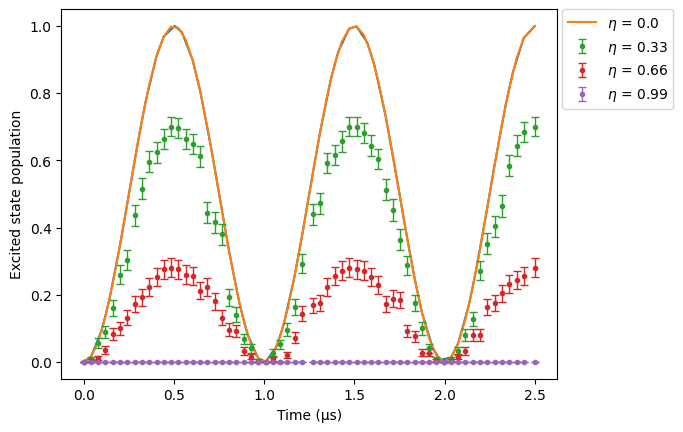

In [22]:
res_clean.plot(obs)
for eta in np.linspace(0, 0.99, 4):
    config_spam_eta = SimConfig(
        noise="SPAM", eta=eta, runs=50, epsilon=0, epsilon_prime=0
    )
    sim.set_config(config_spam_eta)
    sim.run().plot(obs, label=rf"$\eta$ = {eta}")
plt.legend(bbox_to_anchor=(1.01, 1), loc="upper left", borderaxespad=0.0)
plt.ylabel("Excited state population")
plt.show()

As $\eta$ grows, more qubits are badly-prepared (i.e, pumped into a state different from $\Ket{g}$) and we stop seeing occupations at all. You can increase the number of runs to smooth the curves.

### Changing $\epsilon$ and $\epsilon'$

Let's now compare sweeps over $\epsilon$ and $\epsilon'$ side by side:

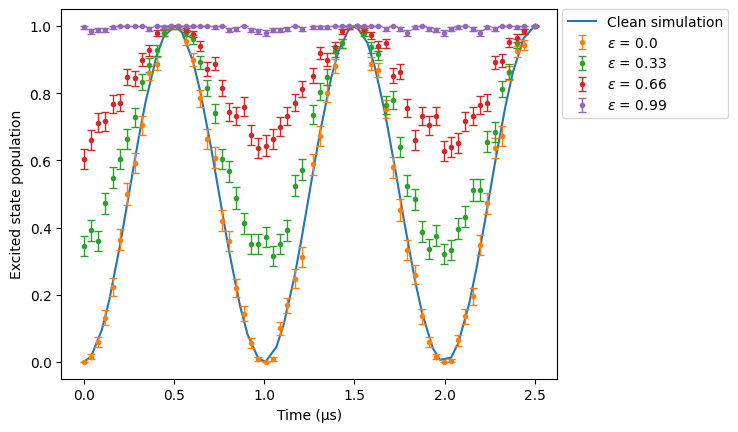

In [23]:
res_clean.plot(obs, label="Clean simulation")
for eps in np.linspace(0, 0.99, 4):
    config_spam_eps = SimConfig(
        noise="SPAM", eta=1e-8, runs=50, epsilon=eps, epsilon_prime=0
    )
    sim.set_config(config_spam_eps)
    sim.run().plot(obs, label=rf"$\epsilon$ = {eps}")
plt.legend(bbox_to_anchor=(1.01, 1), loc="upper left", borderaxespad=0.0)
plt.ylabel("Excited state population")
plt.show()

When we increase the proportion of false positives, the percentage of atoms in the excited state increases as expected. Note that when $\eta=0$, the object we obtain is a `CoherentResults` rather than a `NoisyResults` since the randomness comes from measurements alone.

Finally, we sweep over the $\epsilon '$ values:

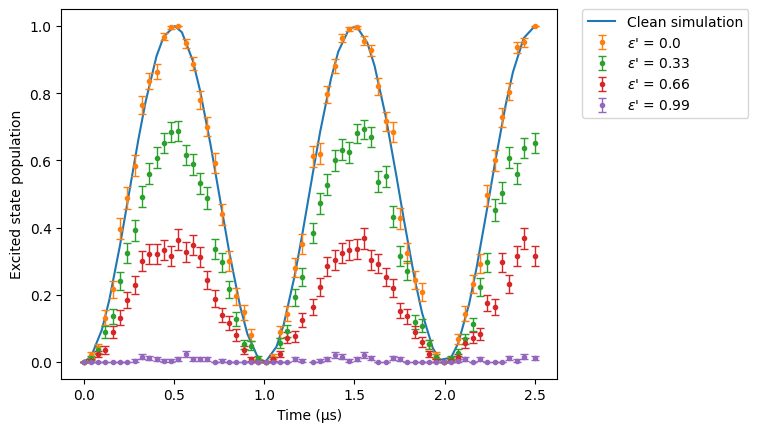

In [24]:
res_clean.plot(obs, label="Clean simulation")
for eps_p in np.linspace(0, 0.99, 4):
    config_spam_eps_p = SimConfig(
        noise="SPAM", eta=1e-8, runs=50, epsilon=0, epsilon_prime=eps_p
    )
    sim.set_config(config_spam_eps_p)
    sim.run().plot(obs, label=rf"$\epsilon$' = {eps_p}")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0)
plt.ylabel("Excited state population")
plt.show()

Unlike the previous case, when the number of false negatives increases, the system behaves as if all atoms are in the ground state leading to a zero population in the excited state.